In [1]:
library(tidyverse)
library(here)
library(glue)
library(furrr)
library(cowplot)
library(lemon)

devtools::load_all(".")

plan(multiprocess, workers = 25)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
here() starts at /mnt/expressions/mp/ychr

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse

Loading required package: future

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘lemon’

The following object is masked from ‘package:purrr’:

    %||%

Loading ychr


In [2]:
traj <-
    future_map_dfr(1:50, function(rep) {
    map_dfr(sprintf("%d", seq(100000, 2000000, 100000)), function(gene_total) {
    map_dfr(sprintf("%d", (seq(200000, 450000, 25000))), function(admix_time) {

        f <- here(glue("data/sim/load/seq{gene_total}_time{admix_time}_rep{rep}_traj.tsv"))

        read_tsv(f, col_types = "id") %>%
            mutate(admix_rate = 0.05,
                   gene_total = as.integer(gene_total),
                   admix_time = as.integer(admix_time),
                   rep = rep)

    })
    })
    }) %>%
    mutate_all(as.numeric)

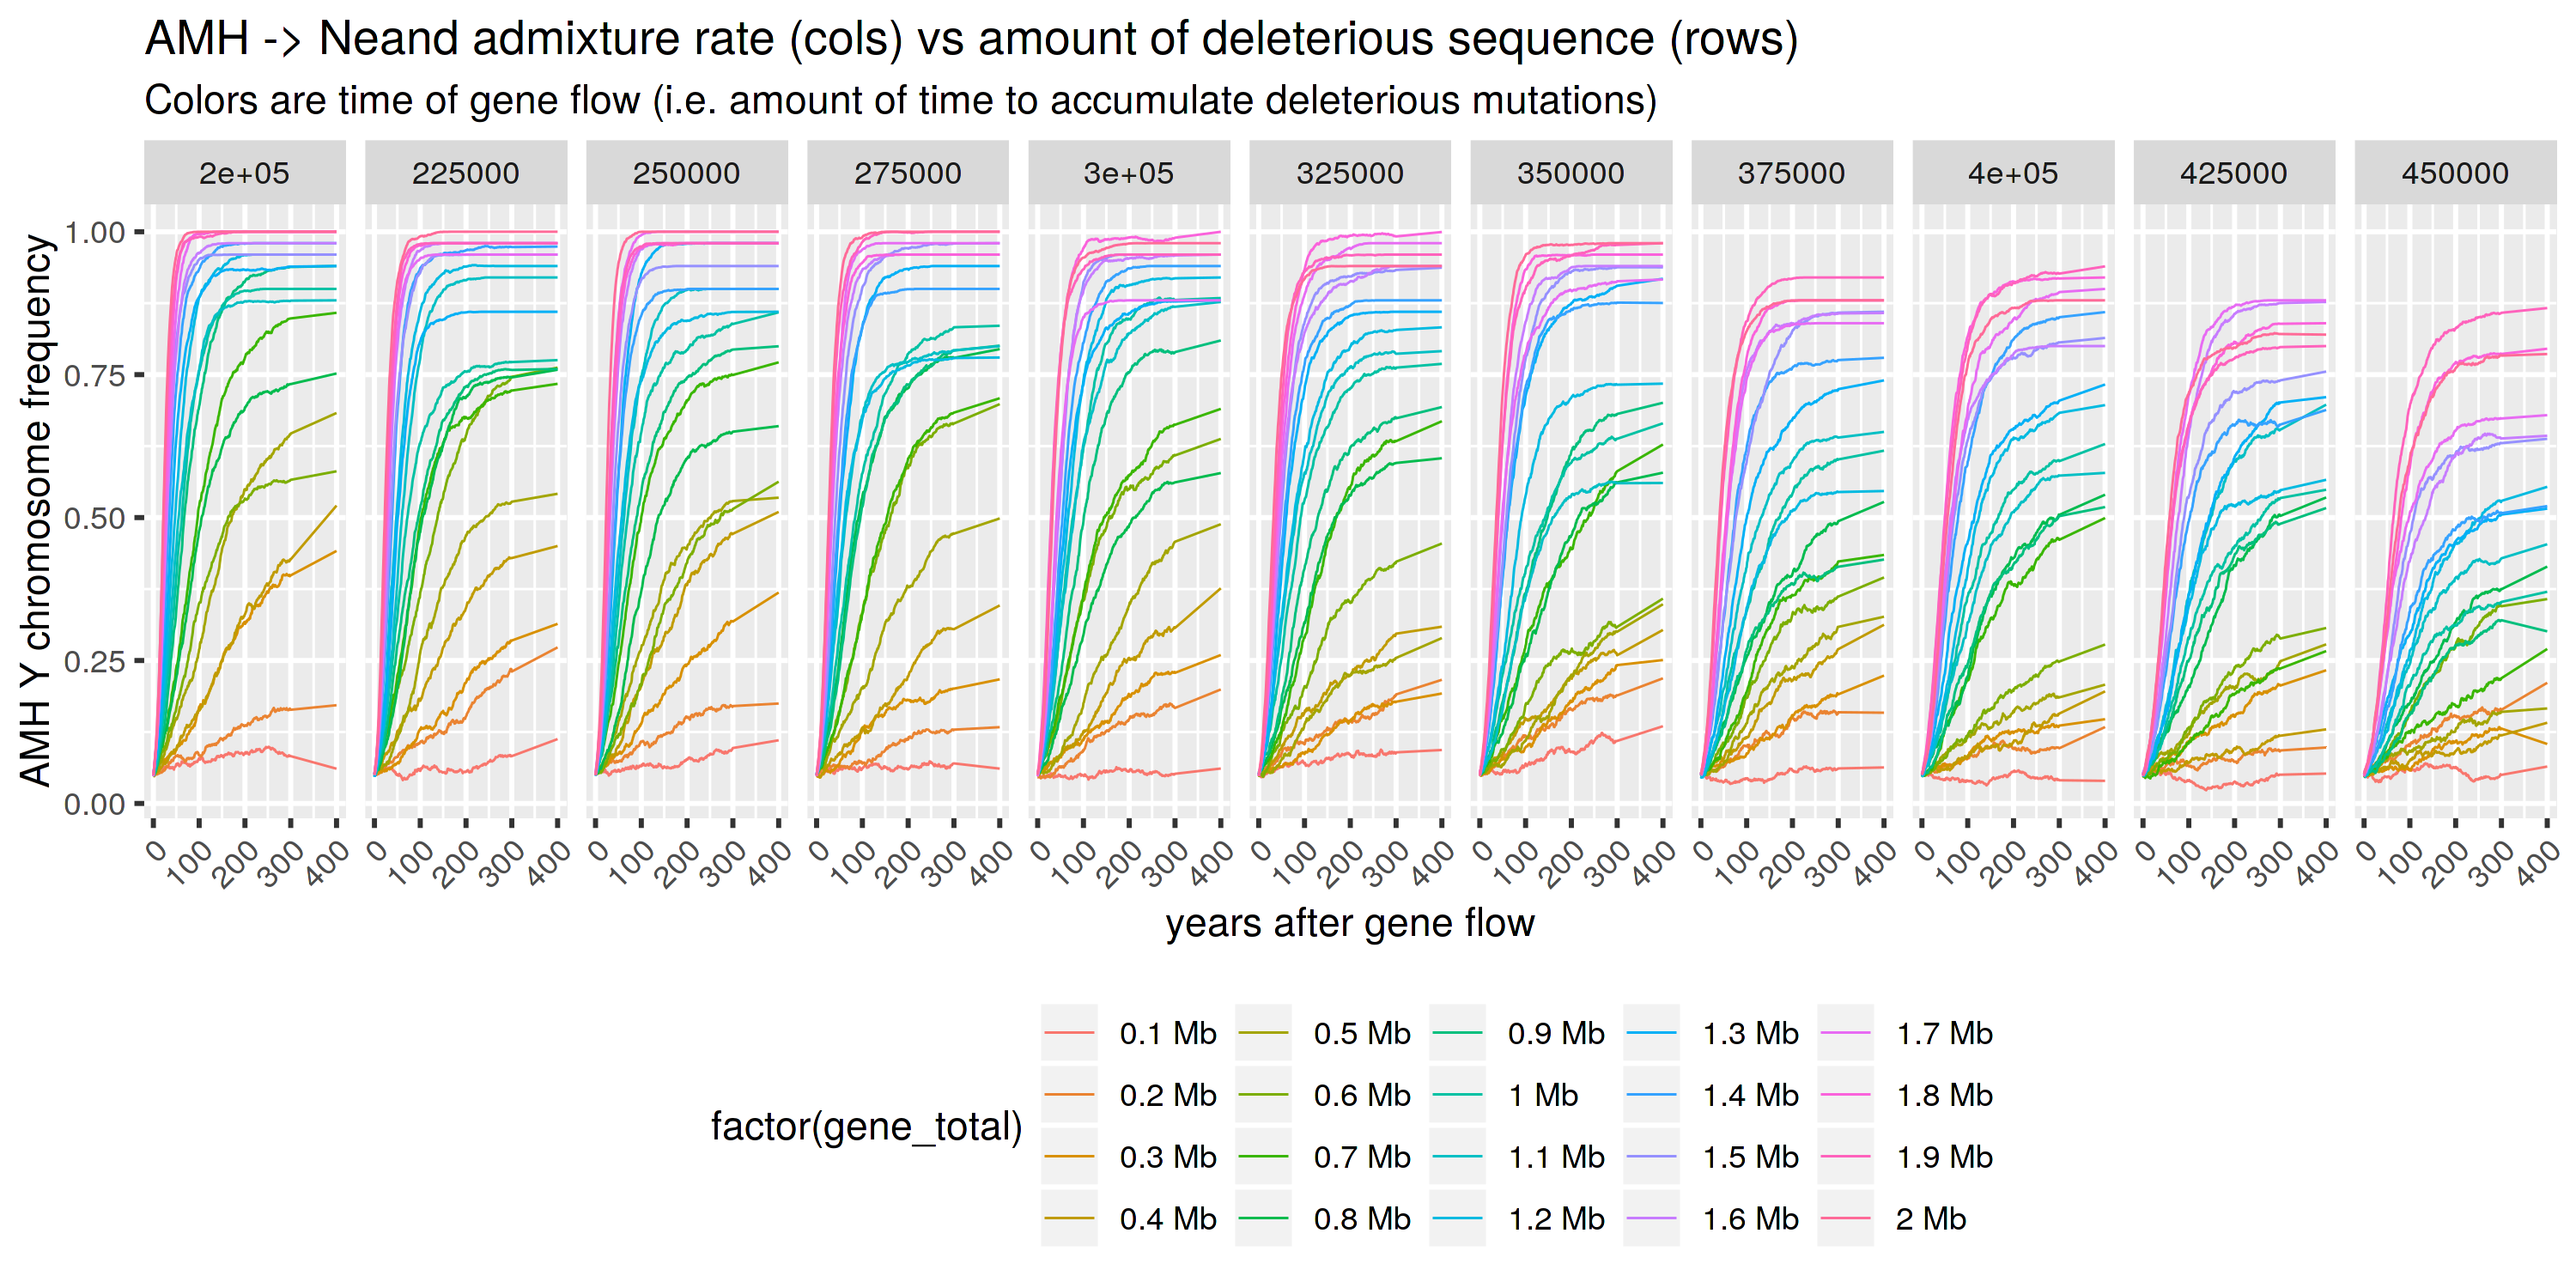

In [3]:
set_dim(10, 5)

traj %>%
filter(gen < 500) %>%
mutate(gene_total = paste(gene_total / 1e6, "Mb")) %>%
group_by(gen, gene_total, admix_time, admix_rate) %>%
summarise_at(vars(ancestry), ~ mean(.x)) %>%
ggplot(aes(gen, ancestry, color = factor(gene_total))) +
    geom_line(size = 0.25) +
    ggtitle("AMH -> Neand admixture rate (cols) vs amount of deleterious sequence (rows)",
            "Colors are time of gene flow (i.e. amount of time to accumulate deleterious mutations)") +
    xlab("years after gene flow") + ylab("AMH Y chromosome frequency") +
    facet_grid(~ admix_time) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

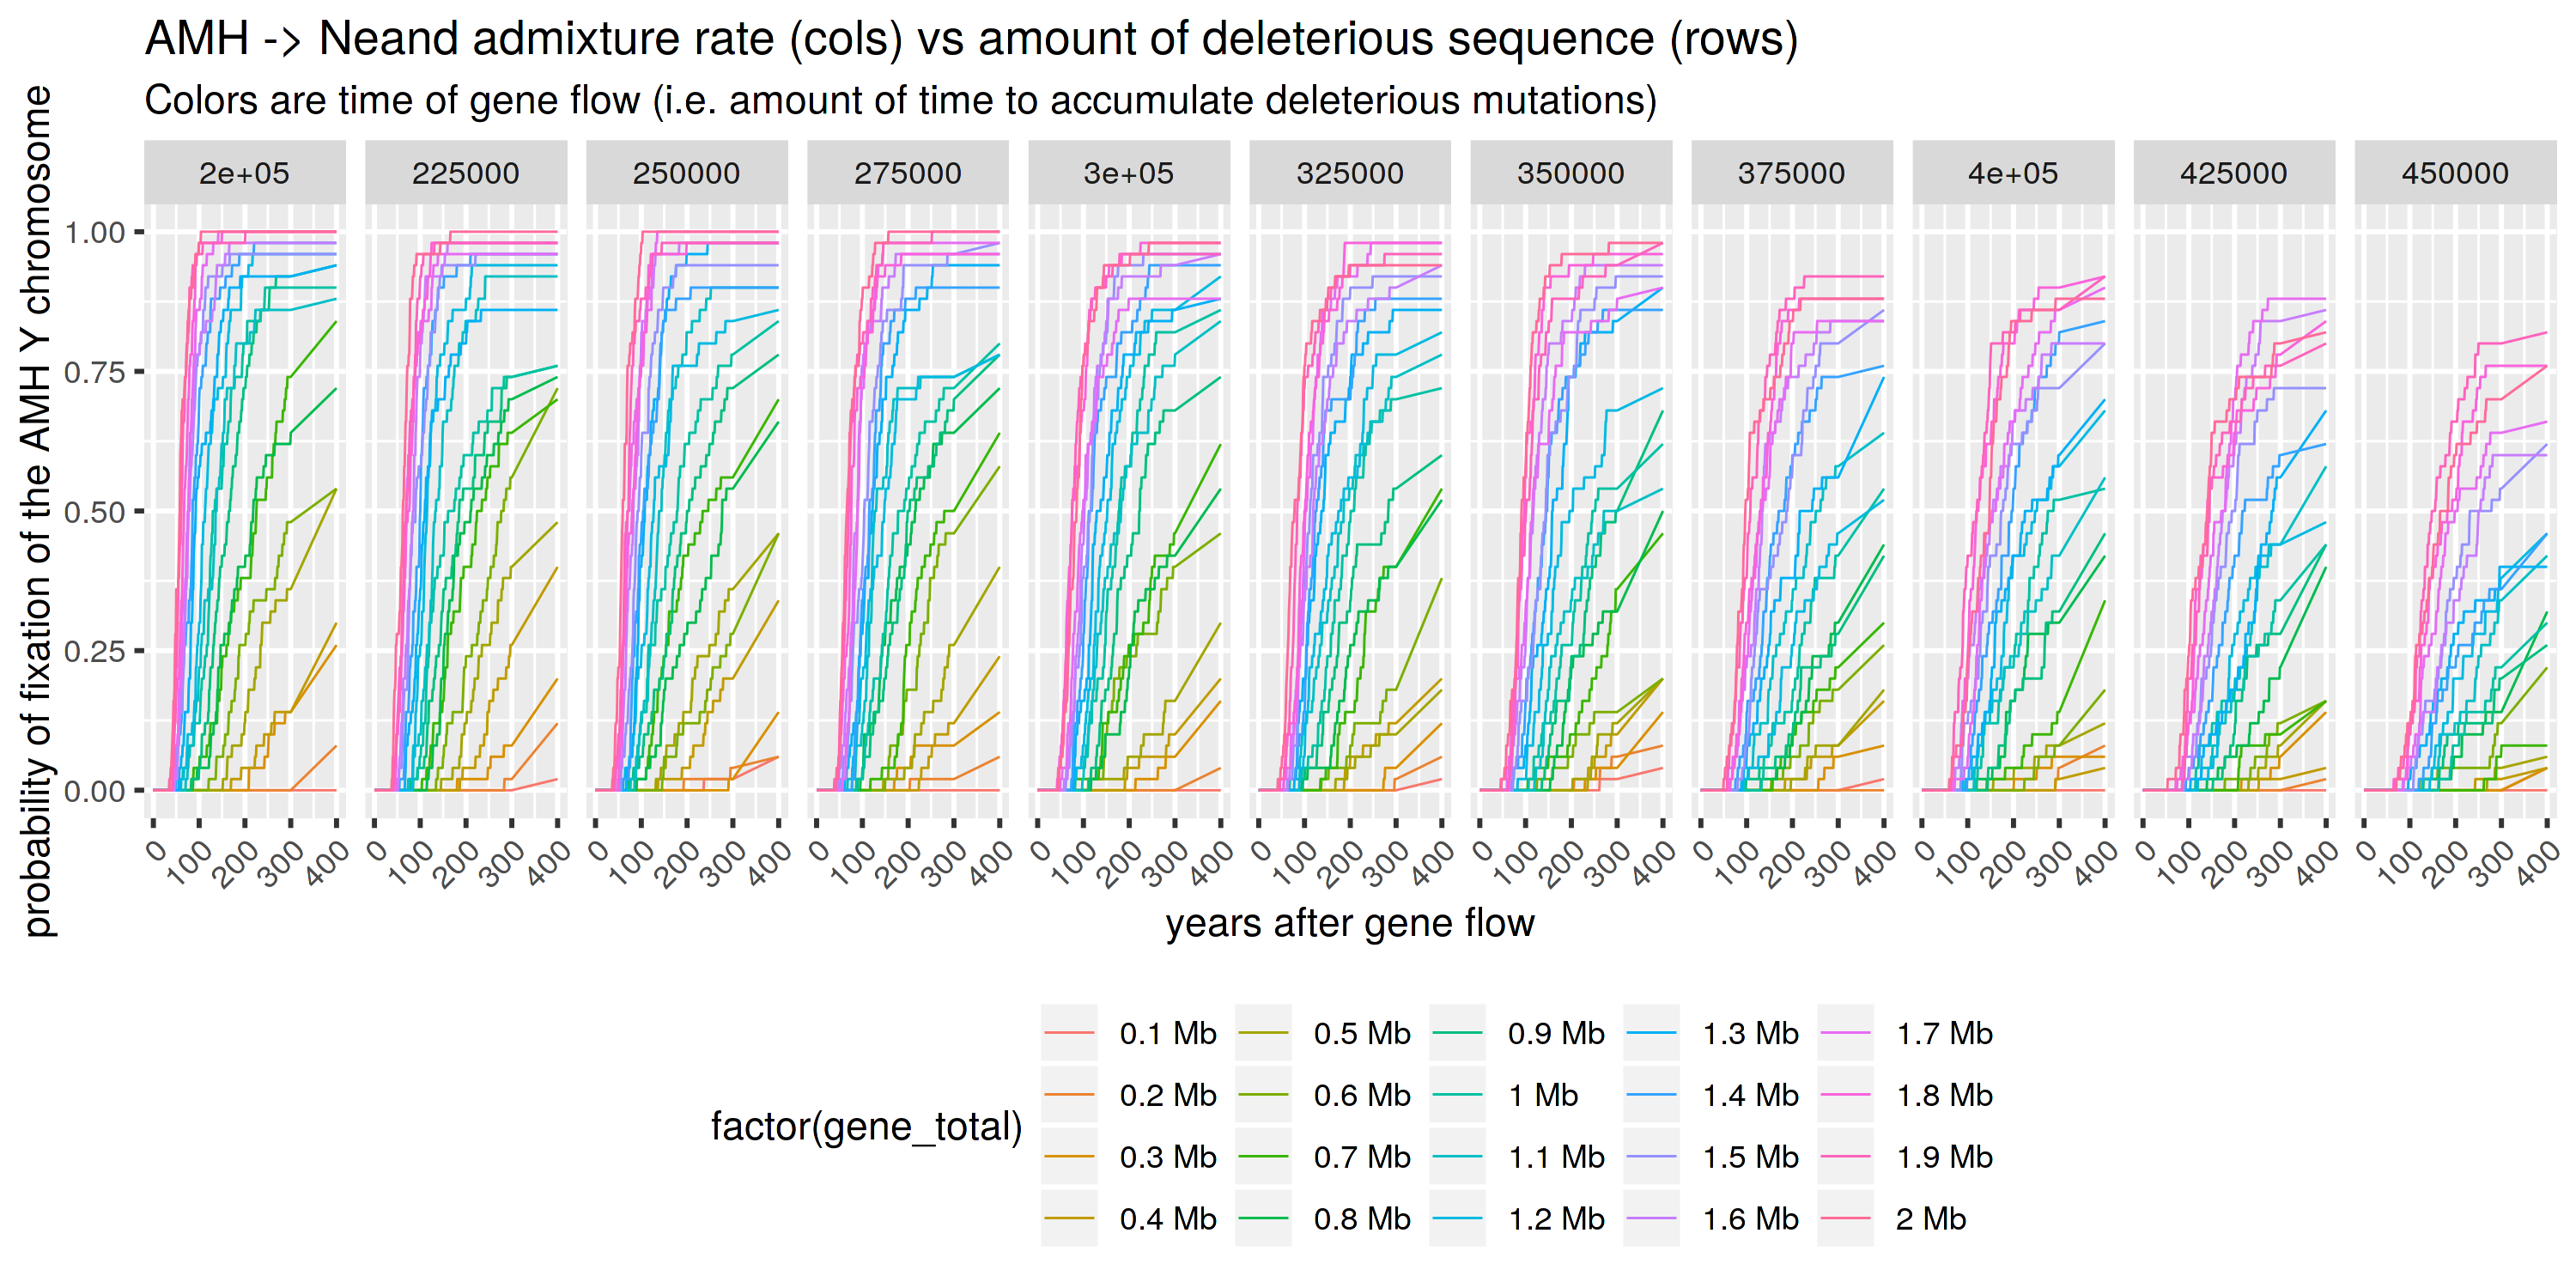

In [4]:
set_dim(10, 5)

traj %>%
filter(gen < 500) %>%
mutate(gene_total = paste(gene_total / 1e6, "Mb")) %>%
group_by(gen, gene_total, admix_time, admix_rate) %>%
summarise_at(vars(ancestry), ~ mean(.x == 1)) %>%
ggplot(aes(gen, ancestry, color = factor(gene_total))) +
    geom_line(size = 0.25) +
    ggtitle("AMH -> Neand admixture rate (cols) vs amount of deleterious sequence (rows)",
            "Colors are time of gene flow (i.e. amount of time to accumulate deleterious mutations)") +
    xlab("years after gene flow") + ylab("probability of fixation of the AMH Y chromosome") +
    facet_grid(~ admix_time) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

In [3]:
load <-
    future_map_dfr(1:50, function(rep) {
    map_dfr(sprintf("%d", seq(100000, 2000000, 100000)), function(gene_total) {
    map_dfr(sprintf("%d", (seq(200000, 450000, 25000))), function(admix_time) {

        f <- here(glue("data/sim/modern2neand/seq{gene_total}_time{admix_time}_rep{rep}_pop.txt.gz"))

        loads <- read_slim(f) %>%
            calculate_load %>%
            mutate(admix_rate = 0.05,
                   gene_total = as.integer(gene_total),
                   admix_time = as.integer(admix_time),
                   rep = rep)

    })
    })
    }) %>%
    mutate(pop = case_when(pop == "p1" ~ "AMH", pop == "p2" ~ "Neanderthals"))

In [4]:
saveRDS(load, here("data/rds/loads.rds"))

In [5]:
head(load)

genome_id pop s            load      admix_rate gene_total admix_time rep
1 p1:10001  AMH 0.0045105022 0.9954997 0.05       100000     200000     1  
2 p1:10003  AMH 0.0003357825 0.9996643 0.05       100000     200000     1  
3 p1:10005  AMH 0.0007161953 0.9992841 0.05       100000     200000     1  
4 p1:10007  AMH 0.0007161953 0.9992841 0.05       100000     200000     1  
5 p1:10009  AMH 0.0007357703 0.9992645 0.05       100000     200000     1  
6 p1:10011  AMH 0.0007357703 0.9992645 0.05       100000     200000     1

In [12]:
mean_load <- load %>%
    group_by(genome_id, pop, admix_rate, gene_total, admix_time) %>%
    summarise_at(vars(load), mean)

In [13]:
head(mean_load)

genome_id pop admix_rate gene_total admix_time load     
1 p1:10001  AMH 0.05       100000     200000     0.9990535
2 p1:10001  AMH 0.05       100000     225000     0.9987989
3 p1:10001  AMH 0.05       100000     250000     0.9984166
4 p1:10001  AMH 0.05       100000     275000     0.9990312
5 p1:10001  AMH 0.05       100000     300000     0.9986771
6 p1:10001  AMH 0.05       100000     325000     0.9982350

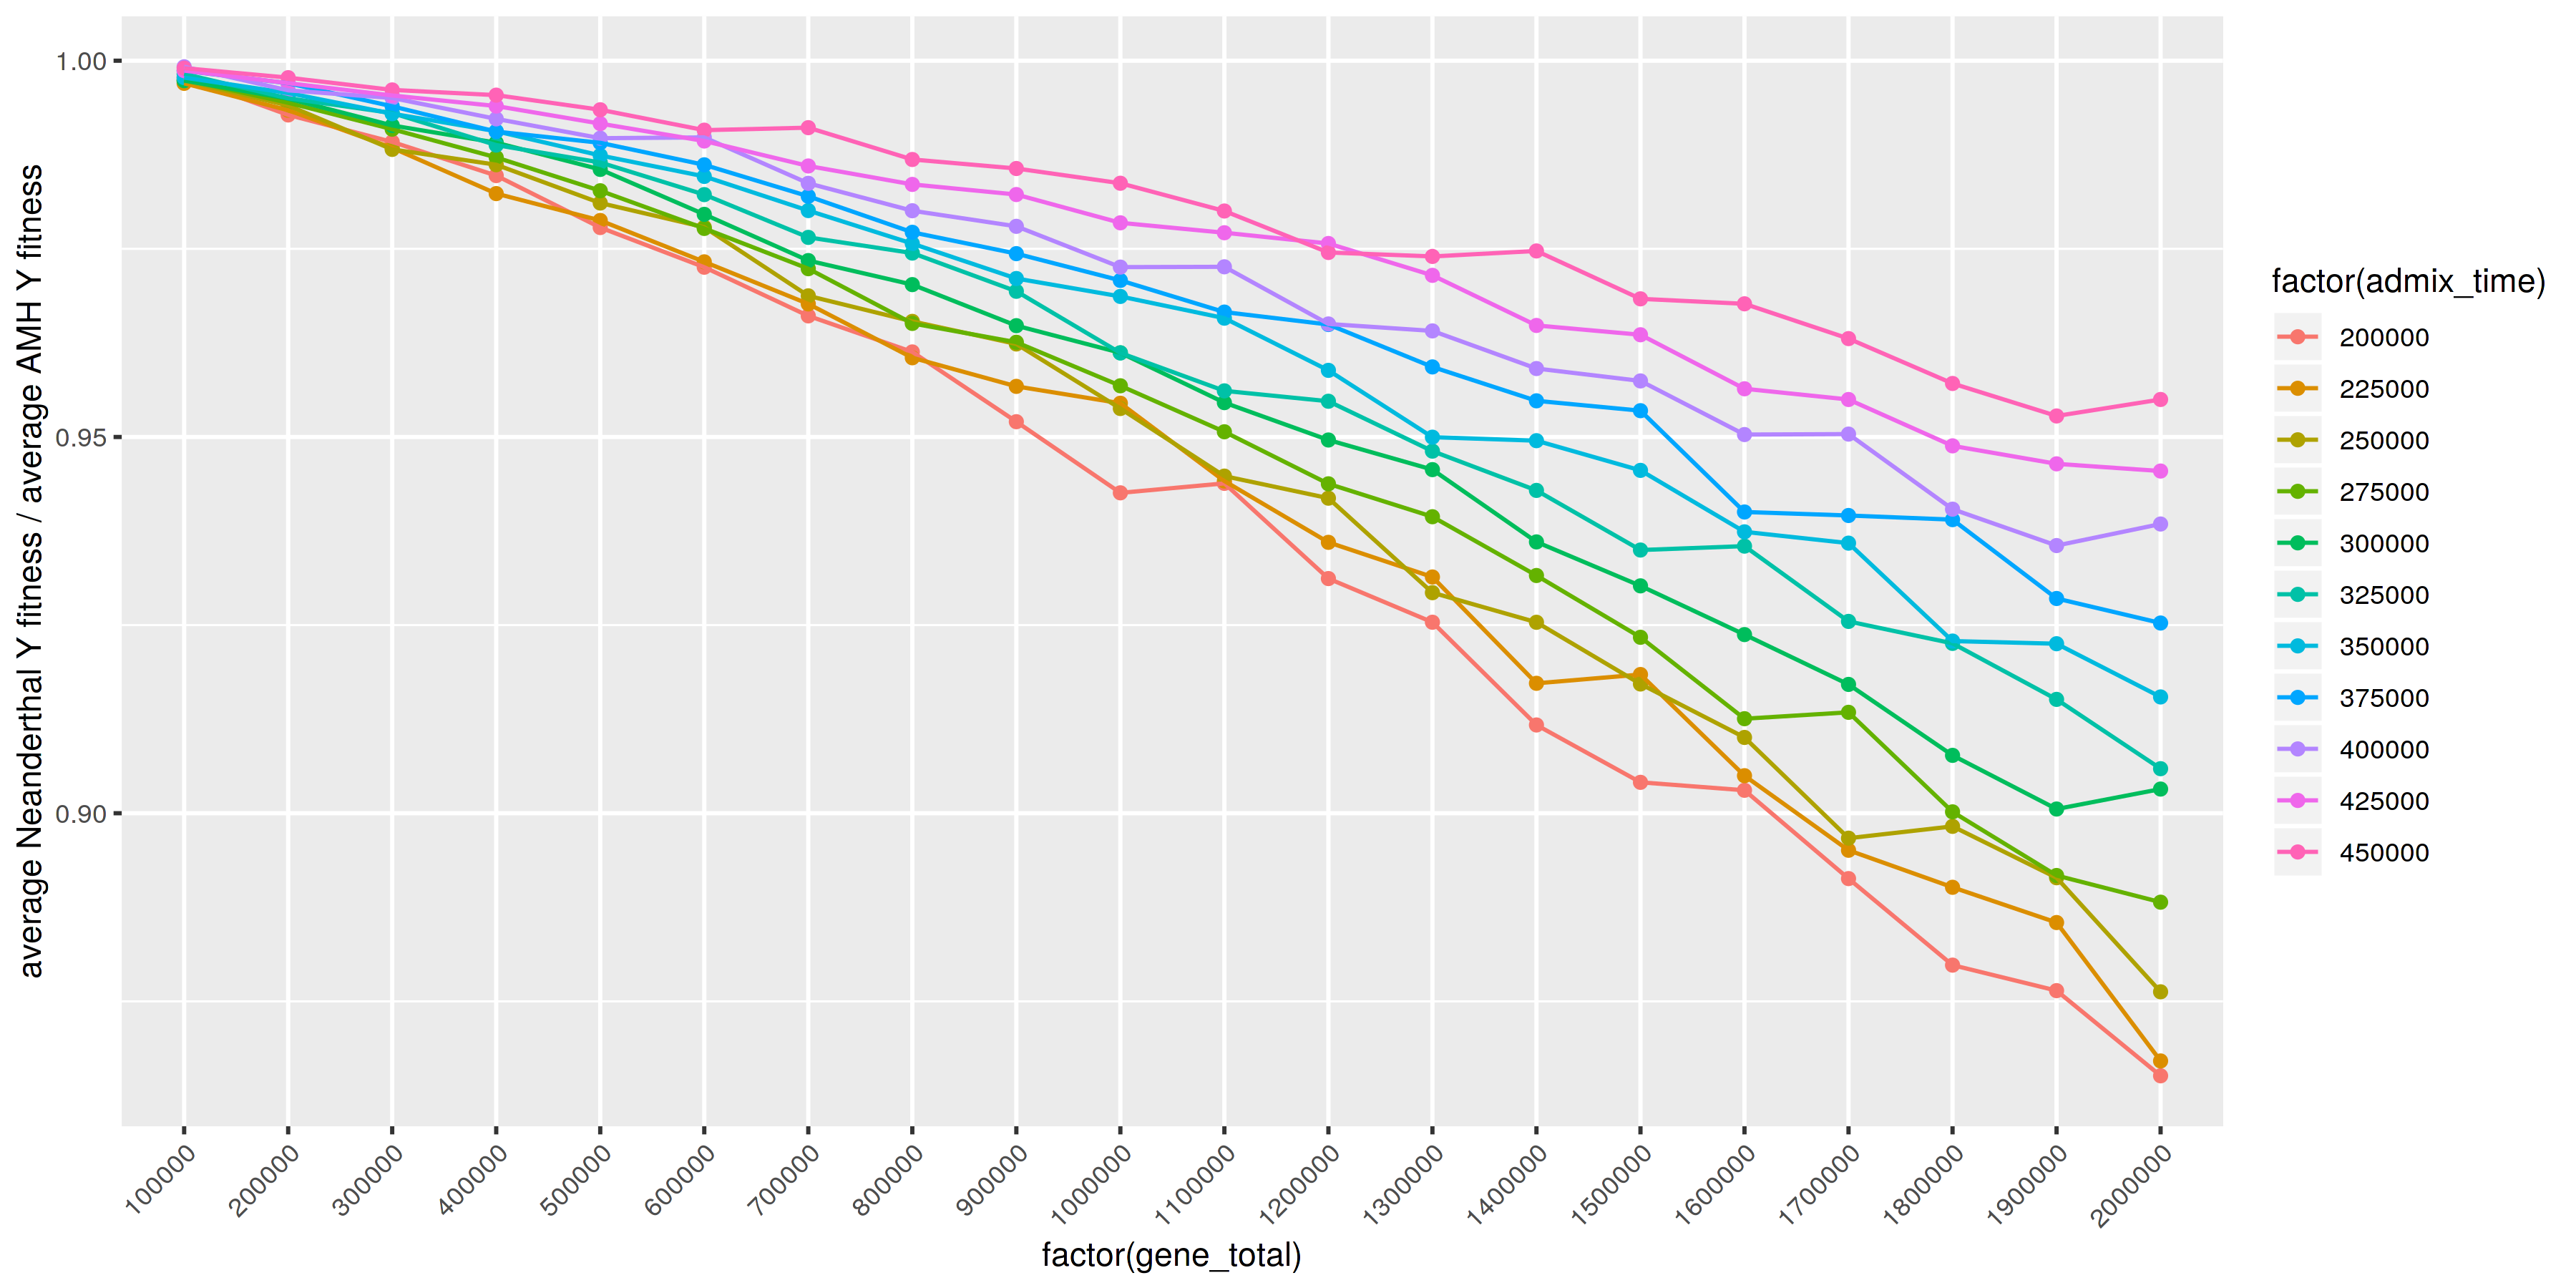

In [26]:
mean_load %>%
group_by(pop, admix_rate, admix_time, gene_total) %>%
summarise_at(vars(load), mean) %>%
spread(pop, load) %>%
mutate(ratio = Neanderthals / AMH) %>%
ggplot(aes(factor(gene_total), ratio, color = factor(admix_time), group = factor(admix_time))) +
    geom_point() +
    geom_line() +
    ylab("average Neanderthal Y fitness / average AMH Y fitness") +
    theme(axis.text.x = element_text(hjust = 1, angle = 45))

In [27]:
traj_load <-
    future_map_dfr(1:50, function(rep) {
    map_dfr(sprintf("%d", seq(100000, 2000000, 100000)), function(gene_total) {
    map_dfr(sprintf("%d", (seq(200000, 450000, 25000))), function(admix_time) {

        path <- here(glue("data/sim/modern2neand/seq{gene_total}_time{admix_time}_rep{rep}"))

        f <- paste0(path, "_pop.txt.gz") %>% read_slim

        load_modern <- calculate_load(f, "p1")
        load_neand <- calculate_load(f, "p2")

        paste0(path, "_traj.tsv") %>%
            read_tsv(col_types = "id") %>%
            mutate(admix_rate = 0.05,
                   gene_total = as.integer(gene_total),
                   admix_time = as.integer(admix_time),
                   rep = rep,
                   mean_modern = mean(load_modern$load),
                   mean_neand = mean(load_neand$load),
                   ratio = mean_neand / mean_modern)

    })
    })
    })

Bin boundaries:

In [81]:
mean_traj_load <- traj_load %>%
    group_by(gen, admix_rate, gene_total, admix_time) %>%
    summarise_at(vars(ancestry, ratio), mean)

In [98]:
(boundaries <- seq(round(min(mean_traj_load$ratio) - 0.01, 2), round(max(mean_traj_load$ratio), 2), 0.01))

[1] 0.86 0.87 0.88 0.89 0.90 0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.00

In [99]:
mean_traj_load <- mean_traj_load %>% 
    mutate(bin = cut(ratio,
                     boundaries,
                     labels = boundaries[-1]))

In [100]:
mean_traj_load$bin %>% table

.
 0.87  0.88  0.89   0.9  0.91  0.92  0.93  0.94  0.95  0.96  0.97  0.98  0.99 
  676  1014   676  2366  2704  3380  3718  5070  5746  7774  8112  9126 10816 
    1 
13182 

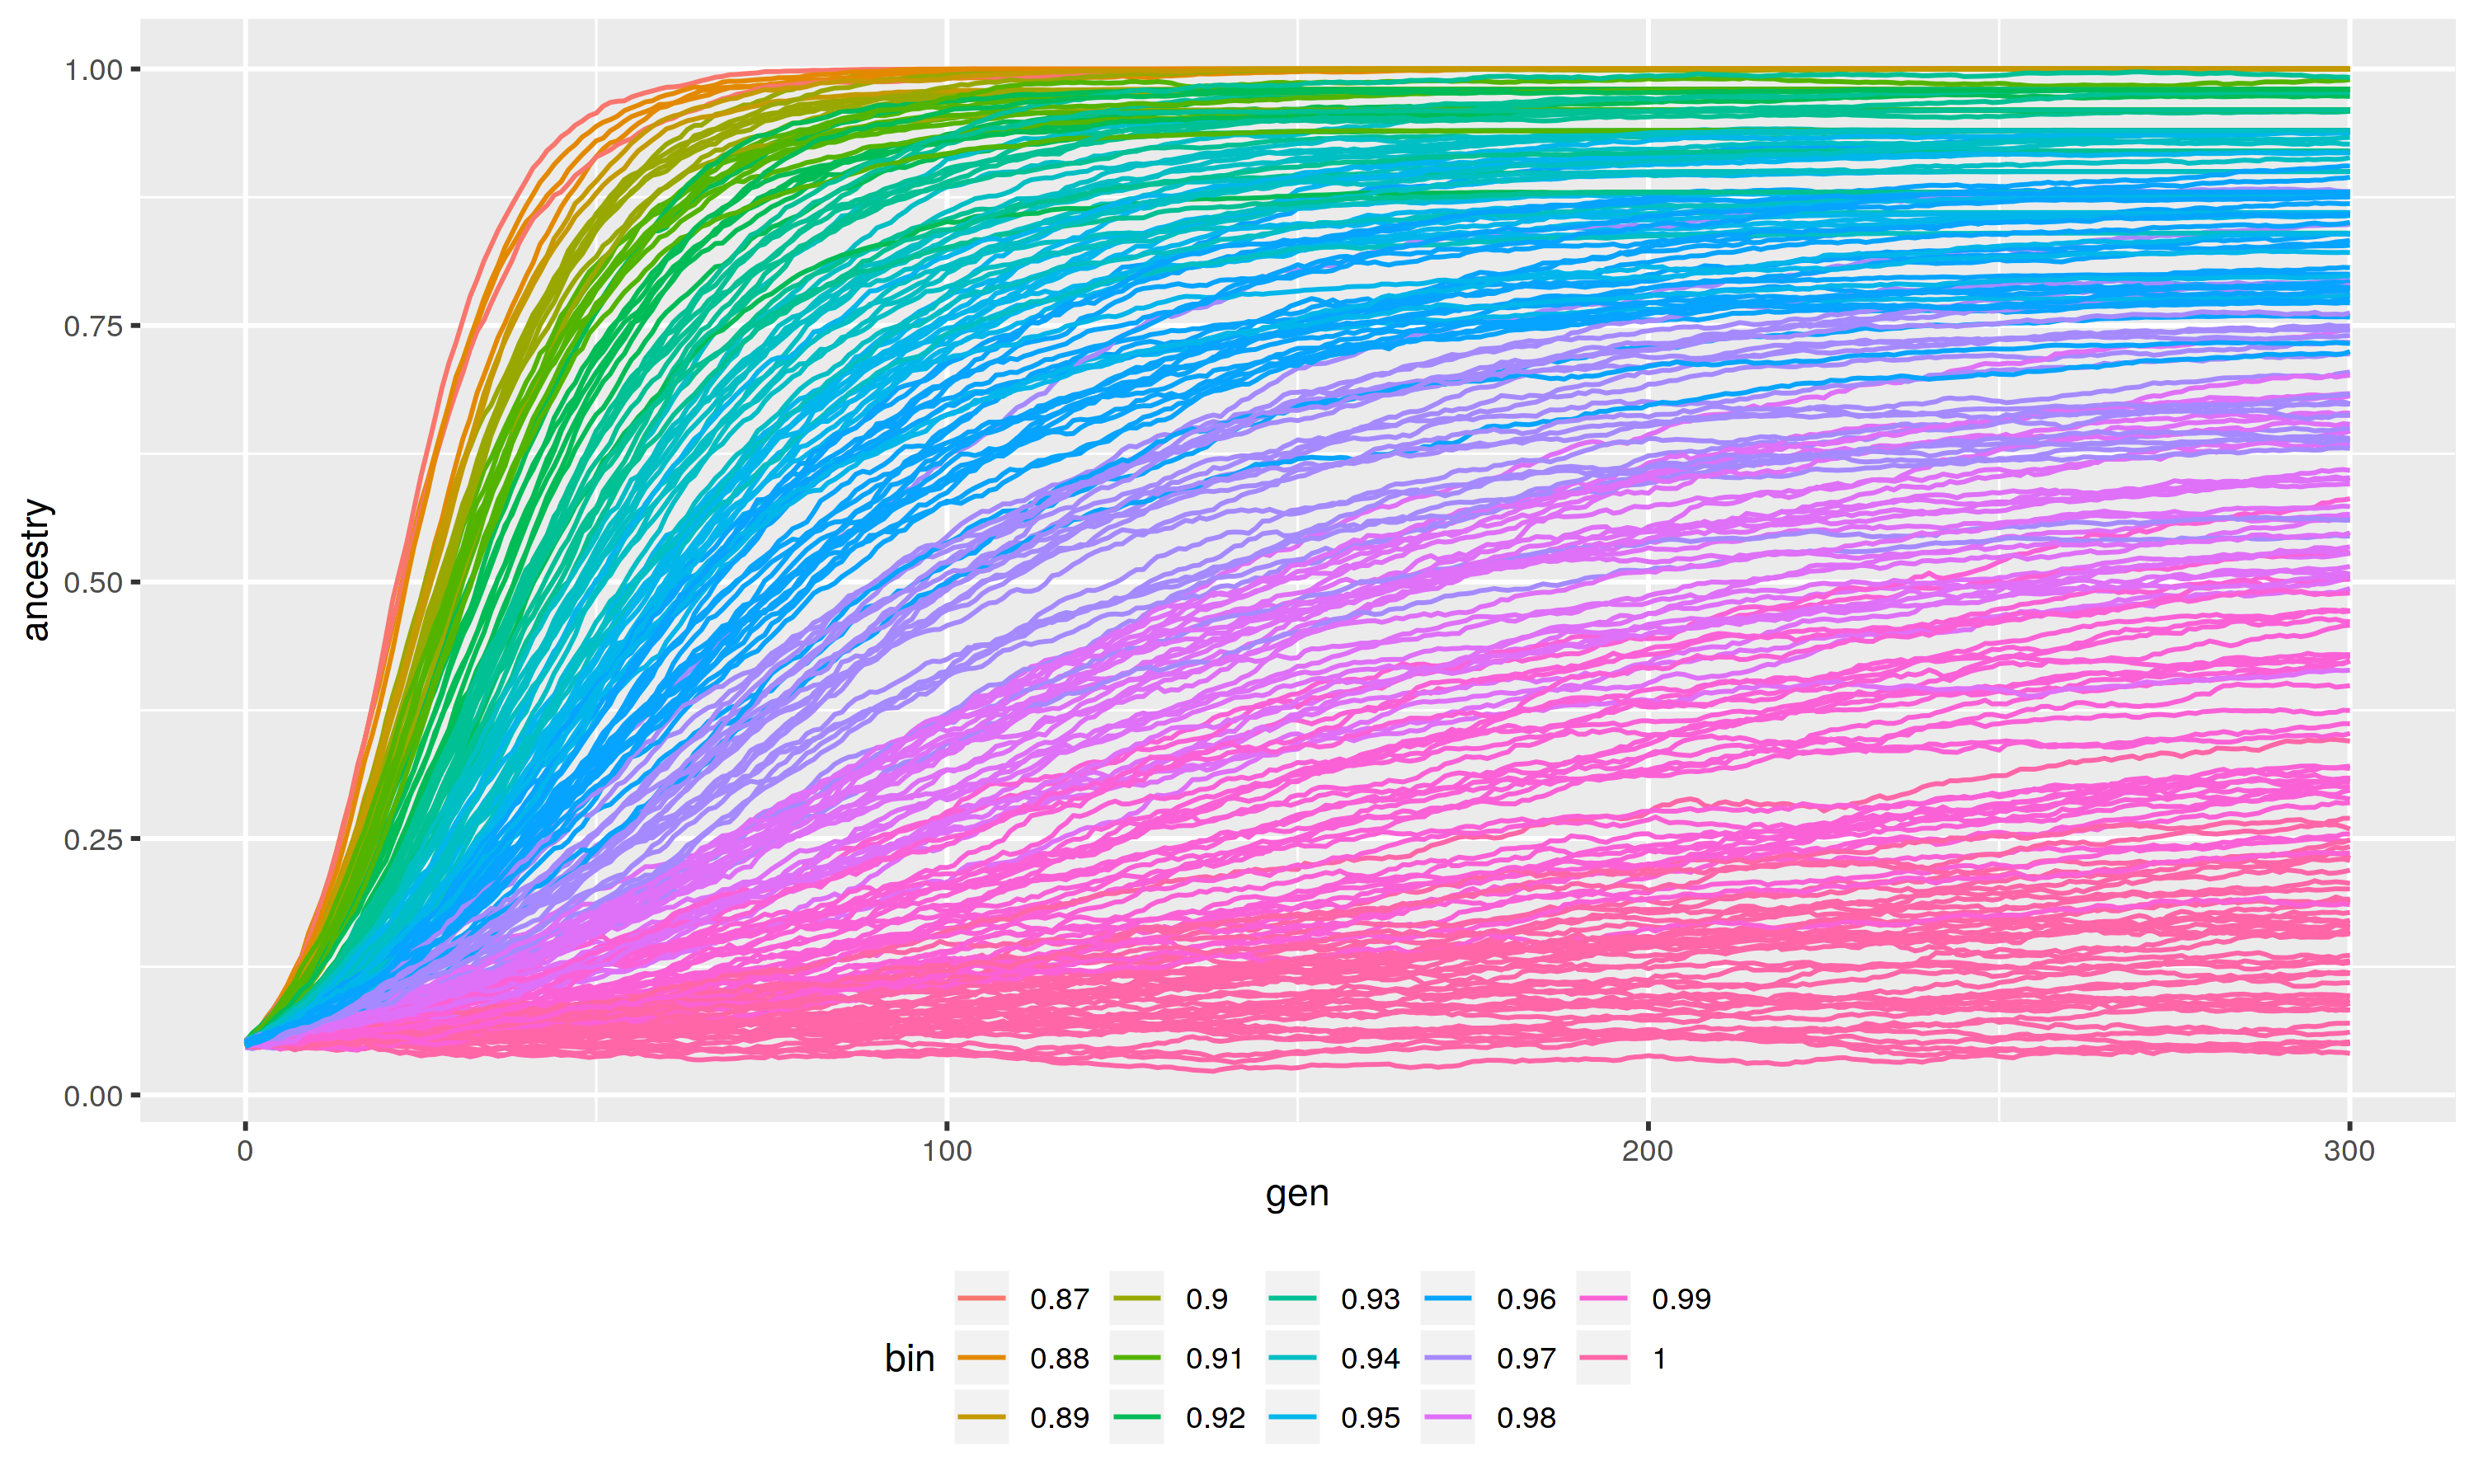

In [101]:
set_dim(10, 6)

mean_traj_load %>%
filter(gen < 400) %>%
ggplot(aes(gen, ancestry, color = bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time))) +
    theme(legend.position = "bottom")

In [109]:
prob_traj_load <- traj_load %>%
    group_by(gen, admix_rate, gene_total, admix_time) %>%
    summarise(ancestry = mean(ancestry == 1), ratio = mean(ratio))

In [110]:
(boundaries <- seq(round(min(prob_traj_load$ratio) - 0.01, 2), round(max(prob_traj_load$ratio), 2), 0.01))

[1] 0.86 0.87 0.88 0.89 0.90 0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.00

In [128]:
prob_traj_load <- prob_traj_load %>% 
    mutate(bin = cut(ratio,
                     boundaries))

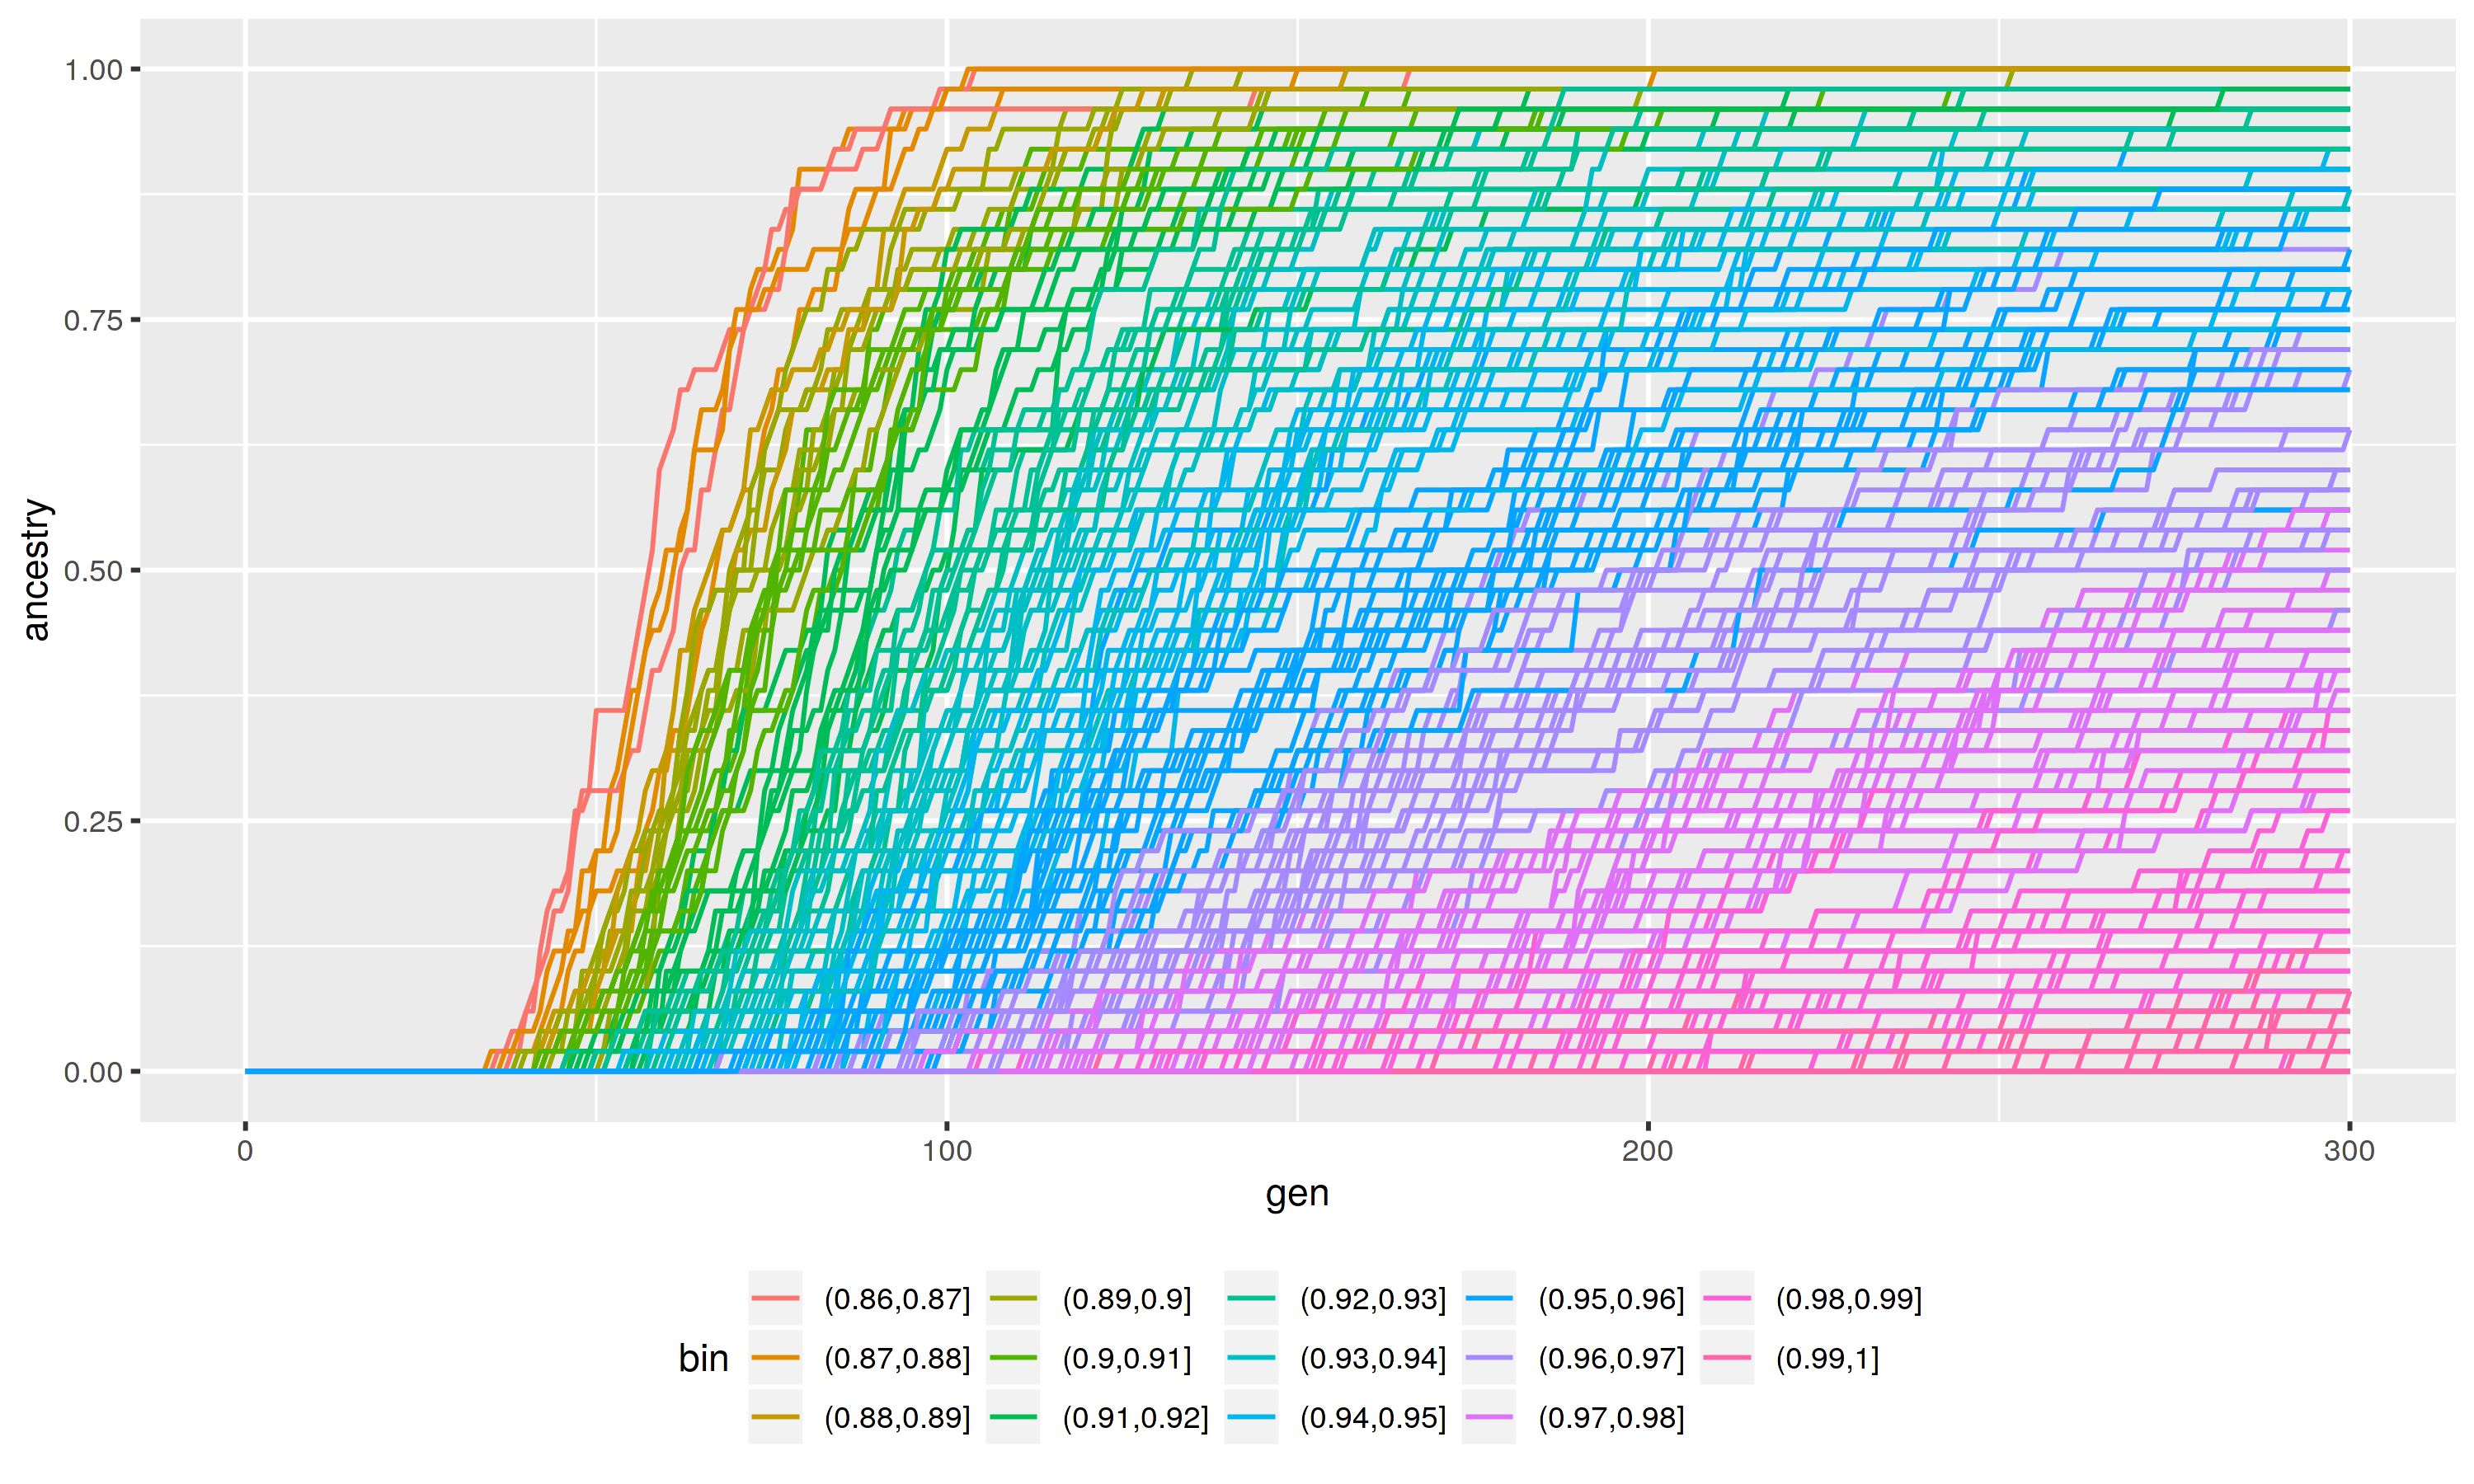

In [129]:
set_dim(10, 6)

prob_traj_load %>%
filter(gen < 400) %>%
ggplot(aes(gen, ancestry, color = bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time))) +
    theme(legend.position = "bottom")

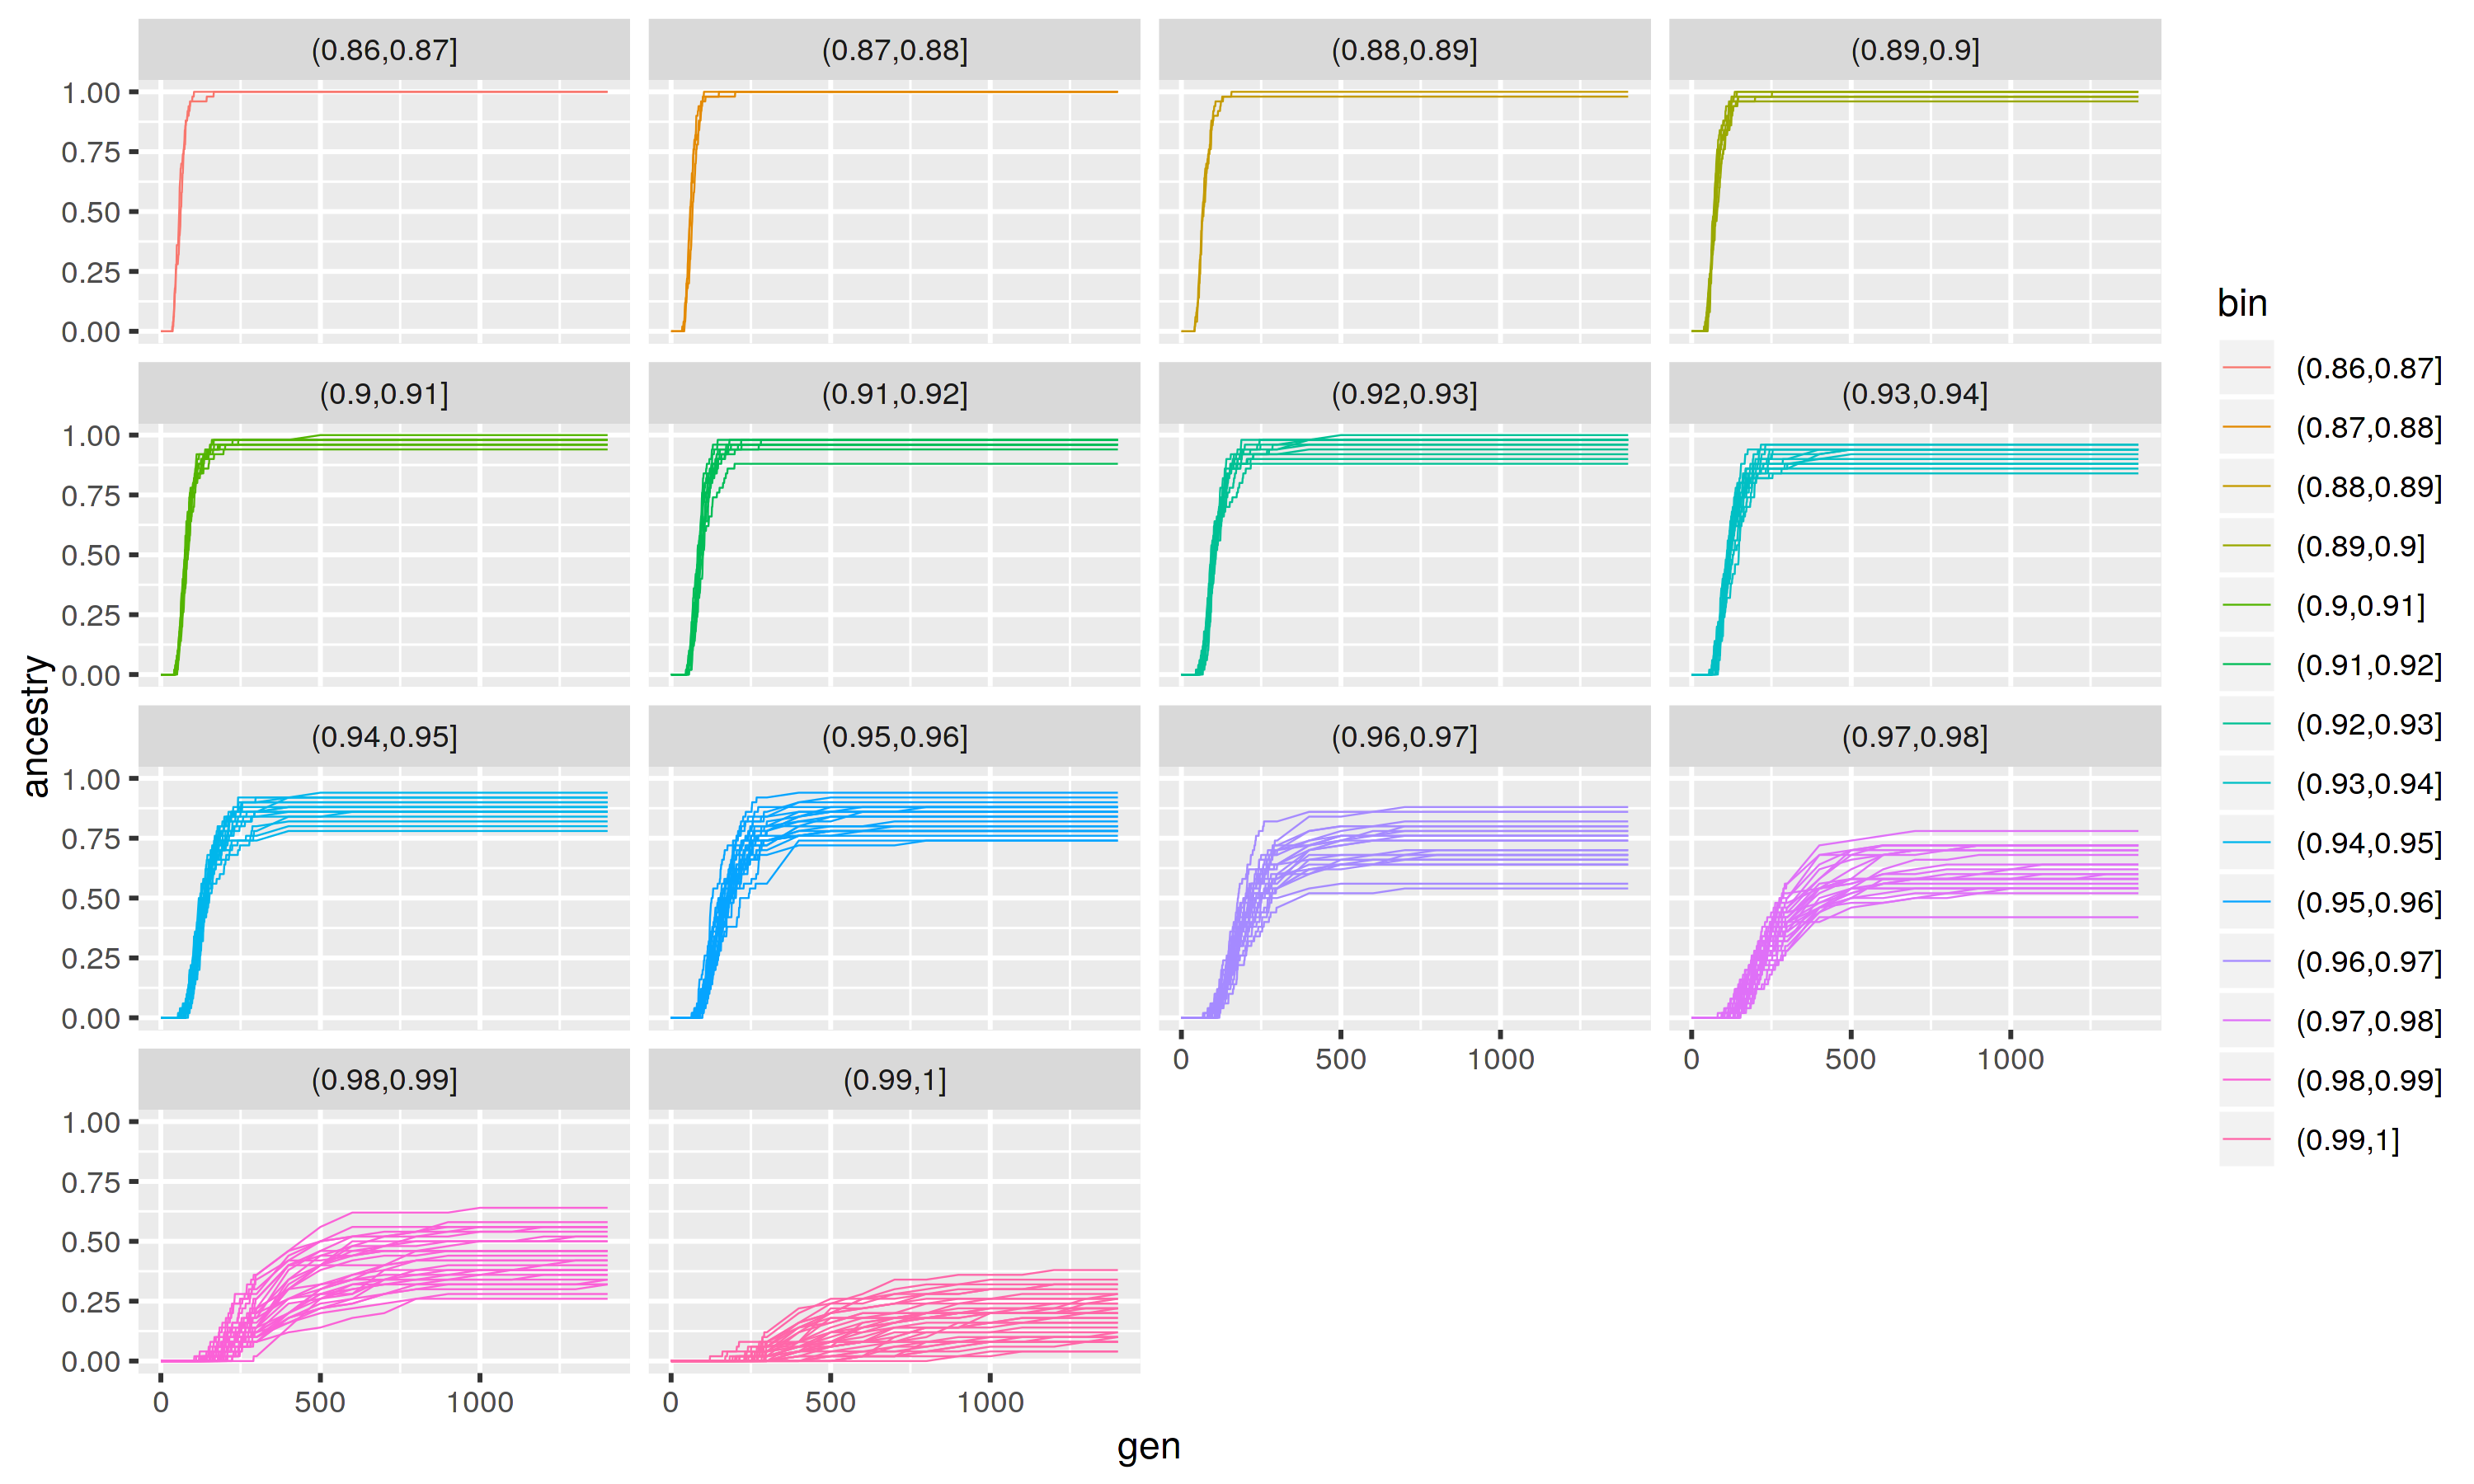

In [130]:
set_dim(10, 6)

prob_traj_load %>%
filter(gen < 1500) %>% 
ggplot(aes(gen, ancestry, color = bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time)), size = 1/5) +
    facet_wrap(~ bin)

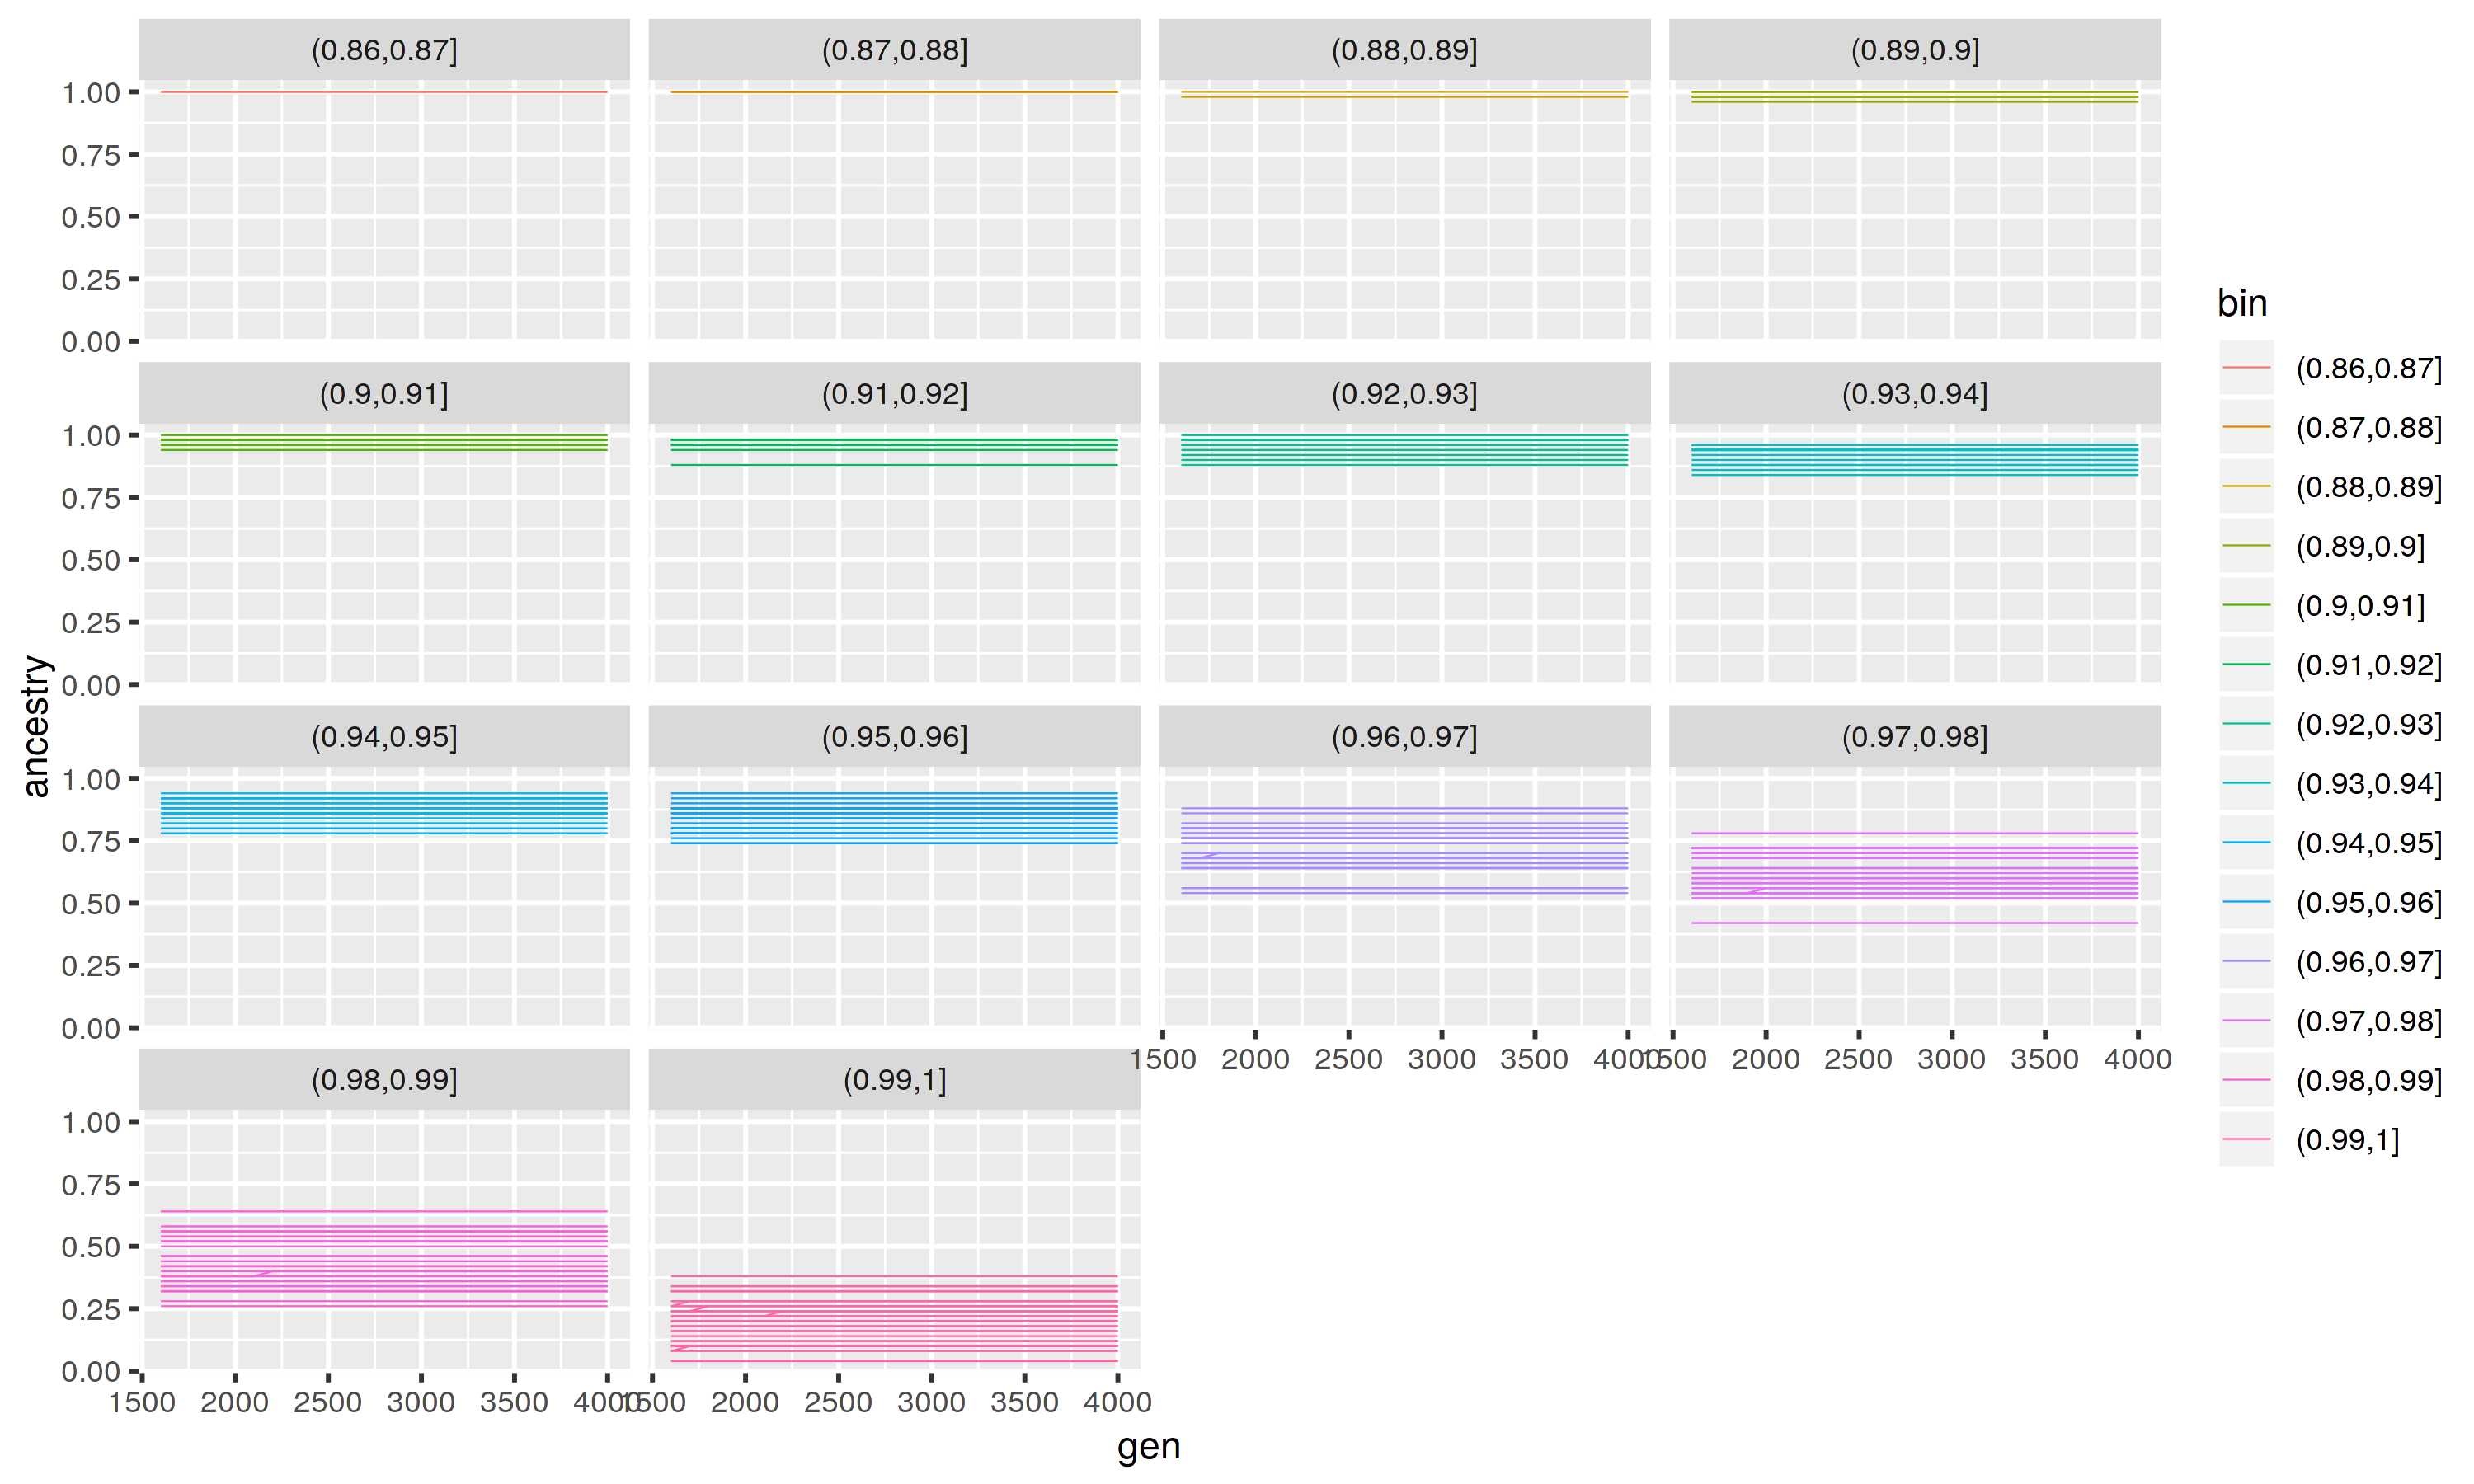

In [131]:
set_dim(10, 6)

prob_traj_load %>%
filter(gen > 1500) %>% 
ggplot(aes(gen, ancestry, color = bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time)), size = 1/5) +
    facet_wrap(~ bin)